## Mortality Weekly Report 12 (12/05)
Rustom Ichhaporia

This week, I was tasked with comparing the LightGBM model that has been training on the HAL cluster with a locally created Logistic Regression from `sklearn`. Below I have compared the two models briefly. I then created functions for generating actionable predictions from either model by using an input of custom data (this assumes that the data has already been dummified, but I can refactor it to dummify the data in the function easily) and created some plots from this output. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from imblearn.over_sampling import SMOTE

sns.set()

First, I read in the 11-year follow-up study data. 

In [2]:
df_raw = pd.read_csv('data/11.csv')

The following variables are completely empty because they are auxilliary in this dataset and only used in separate sets, so they are dropped. 

In [3]:
df_raw = df_raw.drop(columns=['smok100', 'agesmk', 'smokstat', 'smokhome', 'curruse', 'everuse'])

Here, I consolidate the algorithmically generated and manually recorded deaths from the dataset into a single response variable.

In [4]:
df_raw['indmort'] = df_raw['inddea'][(df_raw['inddea'] == 1) & (df_raw['indalg'] == 1)]
df_raw['indmort'] = df_raw['indmort'].fillna(0)

A brief examination of the missing value proportions of the data's features highlights several features with high numbers of NAs.

In [5]:
(df_raw.isna().sum() / df_raw.shape[0]).sort_values()

record      0.000000
stater      0.000000
povpct      0.000000
ssnyn       0.000000
follow      0.000000
cause113    0.000000
inddea      0.000000
hhnum       0.000000
hhid        0.000000
indmort     0.000000
pob         0.000000
age         0.000000
sex         0.000000
wt          0.000000
race        0.001575
reltrf      0.002547
urban       0.007107
smsast      0.007115
tenure      0.013867
adjinc      0.024124
hisp        0.028610
educ        0.191202
esr         0.191220
ms          0.196846
vt          0.215823
histatus    0.314846
hitype      0.314846
rcow        0.465219
majocc      0.466099
occ         0.466099
majind      0.466219
ind         0.466219
citizen     0.746680
health      0.790674
indalg      0.809948
dayod       0.912401
hosp        0.914012
hospd       0.920889
dtype: float64

I proceed to drop the features which have high missing rates or do not make sense to include in the model. 

In [7]:
used_numerical = ['age', 'hhnum']
used_ordinal = ['povpct', 'adjinc']
used_categorical = ['stater', 'pob', 'sex', 'race', 'urban', 'smsast']
used_special = ['wt', 'indmort']

used_features = used_numerical + used_ordinal + used_categorical + used_special

df_raw = df_raw[used_features]

Next, the categorical variables are converted from their native numerical dtype to a category. 

In [8]:
df_raw[used_categorical] = df_raw[used_categorical].astype('category')

Because few entries have NAs after dropping the columns with very high proportions of missing values, all remaining rows containing NAs can be dropped. 

In [9]:
df_raw = df_raw.dropna(axis=0)

No clear outliers are detected in the numerical data; much of this dataset is categorical or ordinally encoded (e.g. `povpct`, `adjinc`). 

<AxesSubplot:>

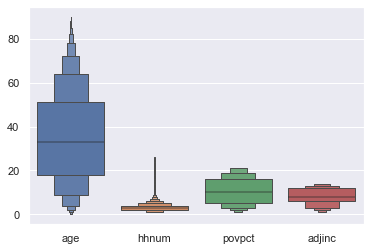

In [26]:
sns.boxenplot(data=df_raw.drop(columns=['wt', 'indmort']))

The categorical variables are then converted into dummy binary variables.

In [10]:
df = pd.get_dummies(df_raw)

A train-test split then separates the data for training and testing purposes with the default partition being 80% of the data being used for training and 20% being used for testing. 

In [11]:
X = df.drop(columns=['indmort'])
y = df['indmort']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Because the binary response variable is highly imbalanced, the Synthetic Minority Oversampling Technique (SMOTE) is used to oversample the minority class in the training data to improve the ability of the model to recognize the minority class amongst frequent instances of the majority class. 

In [13]:
print('Proportion of data from minority class before SMOTE:', y_train.sum() / y_train.shape[0])

X_train, y_train = SMOTE().fit_resample(X_train, y_train)
    
print('Proportion of data from minority class after SMOTE:', y_train.sum() / y_train.shape[0])

Proportion of data from minority class before SMOTE: 0.05225231541739422
Proportion of data from minority class after SMOTE: 0.5


After preprocessing the data, I fitted a logistic regression model using the data on which automated cross validation was performed. The appropriate sample weights were given to each entry to ensure proper representation. 

In [14]:
model = LogisticRegressionCV(scoring='roc_auc', random_state=0, n_jobs=-1, verbose=1).fit(X_train.drop(columns=['wt']), y_train, sample_weight=X_train['wt'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 167.3min finished


In [15]:
print(classification_report(model.predict(X_test.drop(columns=['wt'])), y_test))

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97    429742
         1.0       0.30      0.41      0.35     17154

    accuracy                           0.94    446896
   macro avg       0.64      0.69      0.66    446896
weighted avg       0.95      0.94      0.95    446896



In [16]:
pred_probs = model.predict_proba(X_test.drop(columns=['wt']))[:, 1]

I believe the best offset may be around +0.25 probability threshold. 

In [17]:
print(classification_report(np.round(pred_probs + 0.25), y_test, sample_weight=X_test['wt']))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95 52909867.0
         1.0       0.61      0.29      0.39 6546873.0

    accuracy                           0.90 59456740.0
   macro avg       0.76      0.63      0.67 59456740.0
weighted avg       0.88      0.90      0.89 59456740.0



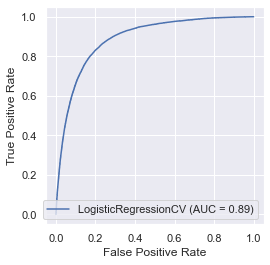

In [18]:
plot_roc_curve(model, X_test.drop(columns=['wt']), y_test, sample_weight=X_test['wt'])
plt.gca().set_aspect('equal')

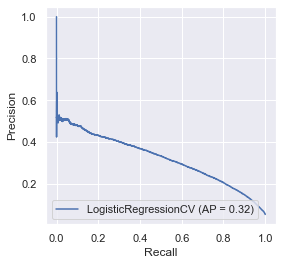

In [19]:
plot_precision_recall_curve(model, X_test.drop(columns=['wt']), y_test, sample_weight=X_test['wt'])
plt.gca().set_aspect('equal')

In [20]:
roc_auc_score(np.round(pred_probs), y_test, sample_weight=X_test['wt'])

0.6848029287350859

The optimized LightGBM model reached an ROC AUC score of 0.90 and f1 score of 0.43. It can be substituted for this model if desired, but this model is far faster to train and has comparable precision and recall. My final report will include a python script version of the Juypter Notebooks for these models. 

Below I have created a function that takes in either a pandas Series or DataFrame with the apporpriate variables and creates a mortality likelihood distribution for equally spaced ages. 

In [21]:
AGE_INTERVAL = 10
MAX_AGE = 100

def mort_dist(people: pd.DataFrame):
    # Handle series instead of DataFrame
    if isinstance(people, pd.Series):
        people = people.to_frame().T

    # Remove weight column if present
    if 'wt' in people.columns: 
        people = people.drop(columns=['wt'])
    
    # Create list of ages to generate mortality predictions
    ages = [num for num in range(0, MAX_AGE, AGE_INTERVAL)]
    output = pd.DataFrame().reindex(columns=ages)

    # Reset age of individual and calculate mortality prediction
    for age in ages: 
        people['age'] = age
        output[age] = model.predict_proba(people)[:, 1]

    # Copy indices
    output = output.set_index(people.index)
    
    return output

In [22]:
pred_dist = mort_dist(X_test)

The plot below showcases some sample variability in the mortality distributions. For example, the individual corresponding to the bottom-most line likely has many socioeconomic factors explained by the model that allow them to live a healthier, lower-risk life as compared to the individual with the top-most line, who crosses the 50% likelihood of mortality before age 70. 

<AxesSubplot:title={'center':'Sample of Predicted Mortality Probability Distributions'}, xlabel='Age', ylabel='Probability of death'>

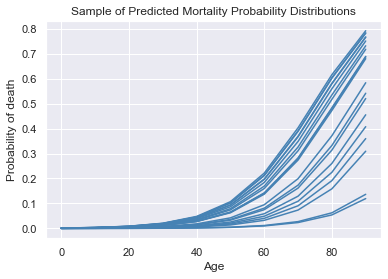

In [23]:
pred_dist.iloc[0:20].T.plot(title='Sample of Predicted Mortality Probability Distributions', xlabel='Age', ylabel='Probability of death', legend=False, color='steelblue')

The plot below demonstrates the large variation in density of mortality likelihoods at different ages. For example, the peak of the age 40 distribution is close to 0 because very few people in the U.S. will die by the age of 40, but the peak of the age 90 distribution is well past the 50% mark at around 0.75, indicating that most people will have died by reaching that age. In the United States, the average life expectancy is roughly 77, slightly below 80, which lines up with the peak of the age 80 distribution occuring slightly below the 0.5 mark. Distributions of age lower than 40 are even more strongly skewed, so they have been omitted for clarity. Please let me know any feedback that I should incorporate before creating the final report. 

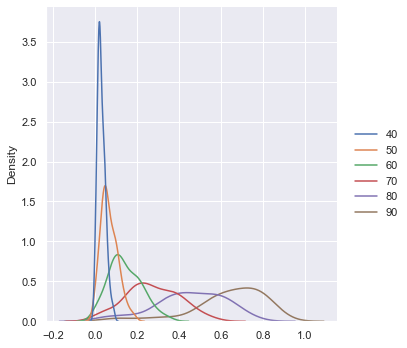

In [24]:
sns.displot(pred_dist.iloc[0:100, 4:], kind='kde')